# Описание проекта #
**Задача**   
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы понять как бороться с данной проблемой, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.  
А именно:  
•	научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
•	сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
•	проанализировать основные признаки, наиболее сильно влияющие на отток;  
•	сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
   1)выделить целевые группы клиентов;  
   2)предложить меры по снижению оттока;  
   3)определить другие особенности взаимодействия с клиентами.



## Шаг 1. Загрузим данные ##

In [1]:
# Импорт библиотек
import pandas as pd
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

#визуализация
import seaborn as sns; sns.set()

#ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

#дополнительные настройки
pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:  

**Данные клиента за предыдущий до проверки факта оттока месяц:**  

**gender** — пол;  
**Near_Location** — проживание или работа в районе, где находится фитнес-центр;  
**Partner** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
**Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
**Phone** — наличие контактного телефона;  
**Age** — возраст;  
**Lifetime** — время с момента первого обращения в фитнес-центр (в месяцах).



**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**  

**Contract_period** — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
**Month_to_end_contract** — срок до окончания текущего действующего абонемента (в месяцах);  
**Group_visits** — факт посещения групповых занятий;  
**Avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента;  
**Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц;  
**Avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
**Churn** — факт оттока в текущем месяце.

In [2]:
#Загружаем таблицу
data = pd.read_csv('/datasets/gym_churn.csv')
data.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Шаг 2. Проведём исследовательский анализ данных (EDA) ## 

In [3]:
#смотрим пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
#проверяем на дубликаты
data.duplicated().sum()

0

In [5]:
#приведём названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [6]:
 #изучим средние значения и стандартные отклонения 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Делаем вывод из полученной таблицы:**  
**Средние значения целевой переменной (churn) и признаков:**  
**gender** (пол) –  **51%**, признак по полу распределился почти одинаково  
**near_location** (проживание или работа рядом в фитнес-центром) – **84%**  
**partner** (сотрудники партнерских организаций) – **48%**  
**promo_friends** ( клиенты пришедшие по акции "Приведи друга") – **30%**  
**phone** ( наличие контактного телефона) – **90%**  
**contract_period** (длительность текущего действующего абонемента) – **4,7 месяцев**  
**group_visits** (посещение групповых занятий) – **41%**  
**age** (возраст) – **29 лет**  
**avg_additional_charges_total** (выручка от других услуг) – **146**  
**month_to_end_contract** (срок окончания абонемента) – **4,3 месяца**  
**lifetime** (время с момента первого посещения) – **3,7 месяцев**  
**avg_class_frequency_total**(частота посещений в неделю) – **около 2 раз**  

**Целевая переменная:**
**churn**(доля оттока) – **27%**


In [7]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 
data.groupby('churn').agg(['count','mean']).T

churn                                              0            1
gender                            count  2939.000000  1061.000000
                                  mean      0.510037     0.510839
near_location                     count  2939.000000  1061.000000
                                  mean      0.873086     0.768143
partner                           count  2939.000000  1061.000000
                                  mean      0.534195     0.355325
promo_friends                     count  2939.000000  1061.000000
                                  mean      0.353522     0.183789
phone                             count  2939.000000  1061.000000
                                  mean      0.903709     0.902922
contract_period                   count  2939.000000  1061.000000
                                  mean      5.747193     1.728558
group_visits                      count  2939.000000  1061.000000
                                  mean      0.464103     0.268615
age                               count  2939.000000  1061.000000
                                  mean     29.976523    26.989632
avg_additional_charges_total      count  2939.000000  1061.000000
                                  mean    158.445715   115.082899
month_to_end_contract             count  2939.000000  1061.000000
                                  mean      5.283089     1.662582
lifetime                          count  2939.000000  1061.000000
                                  mean      4.711807     0.990575
avg_class_frequency_total         count  2939.000000  1061.000000
                                  mean      2.024876     1.474995
avg_class_frequency_current_month count  2939.000000  1061.000000
                                  mean      2.027882     1.044546

Отток : **1061** клиентов  
Остались: **2939** клиентов  

**Средние значения группы «Отток»:**  
**gender** (пол) –  **51%**  
**near_location** (проживание или работа рядом в фитнес-центром) – **77%**  
**partner** (сотрудники партнерских организаций) – **35%**  
**promo_friends** ( клиенты пришедшие по акции "Приведи друга") – **18%**  
**phone** ( наличие контактного телефона) – **90%**  
**contract_period** (длительность текущего действующего абонемента) – **1,7 месяца**  
**group_visits** (посещение групповых занятий) – **26%**  
**age** (возраст) – **26лет**  
**avg_additional_charges_total** (выручка от других услуг) – **115**  
**month_to_end_contract** (срок окончания абонемента) – **1,6 месяца**  
**lifetime** (время с момента первого посещения) – примерно **1,5 месяца**  
**avg_class_frequency_total**(частота посещений в неделю) – **1 раз**


**Средние значения группы «Остались»:**  
**gender** (пол) –  **51%**  
**near_location** (проживание или работа рядом в фитнес-центром) – **87%**  
**partner** (сотрудники партнерских организаций) – **53%**  
**promo_friends** ( клиенты пришедшие по акции "Приведи друга") – **35%**  
**phone** ( наличие контактного телефона) – **90%**  
**contract_period** (длительность текущего действующего абонемента) – около **6 месяцев**  
**group_visits** (посещение групповых занятий) – **46%**  
**age** (возраст) – **30лет**  
**avg_additional_charges_total** (выручка от других услуг) – **158**  
**month_to_end_contract** (срок окончания абонемента) – **5 месяцев**  
**lifetime** (время с момента первого посещения) – примерно **5 месяцев**  
**avg_class_frequency_total**(частота посещений в неделю) – **2 раза**


### Построим столбчатые гистограммы и распределения признаков для тех, кто ушел и тех, кто остался.

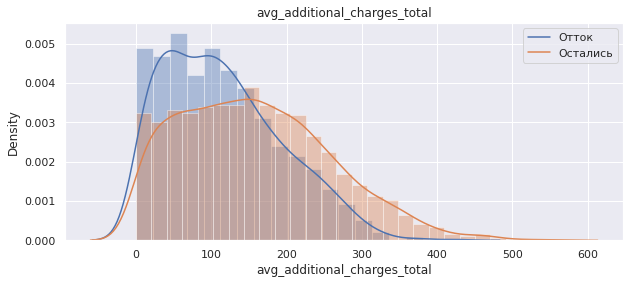

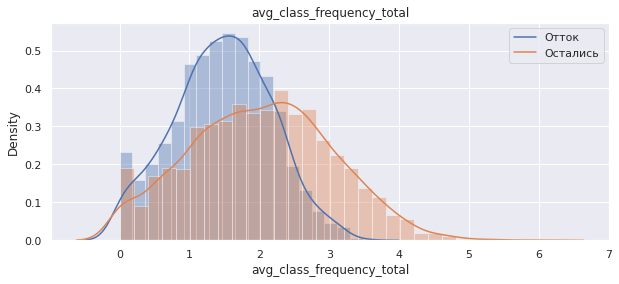

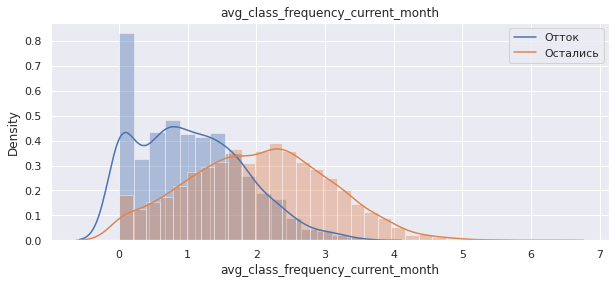

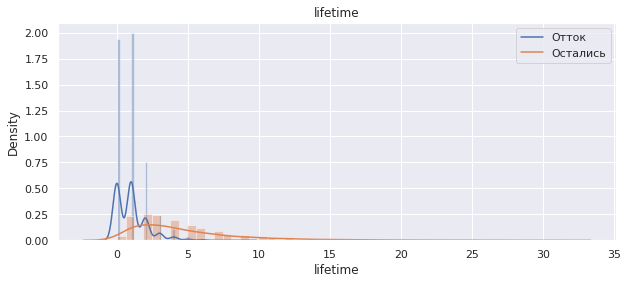

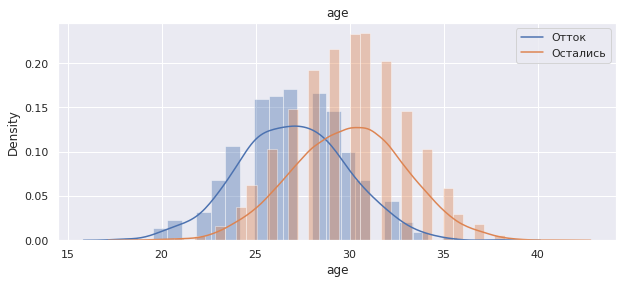

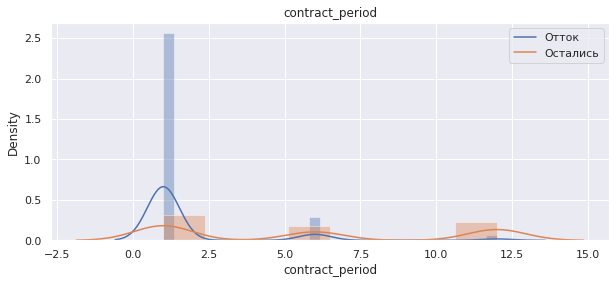

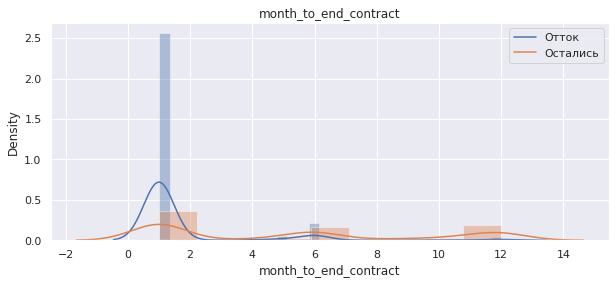

In [47]:
# Визуализируем
gone = data[data['churn']==1]
remained = data[data['churn']==0]
distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']
for column in distplot_columns: 
    plt.figure(figsize=(10,4)) 
    plt.title(column)
    sns.distplot(gone[column])
    sns.distplot(remained[column])
    plt.legend(['Отток', 'Остались'])
    plt.show()

### Построим матрицу корреляций и отобразим её

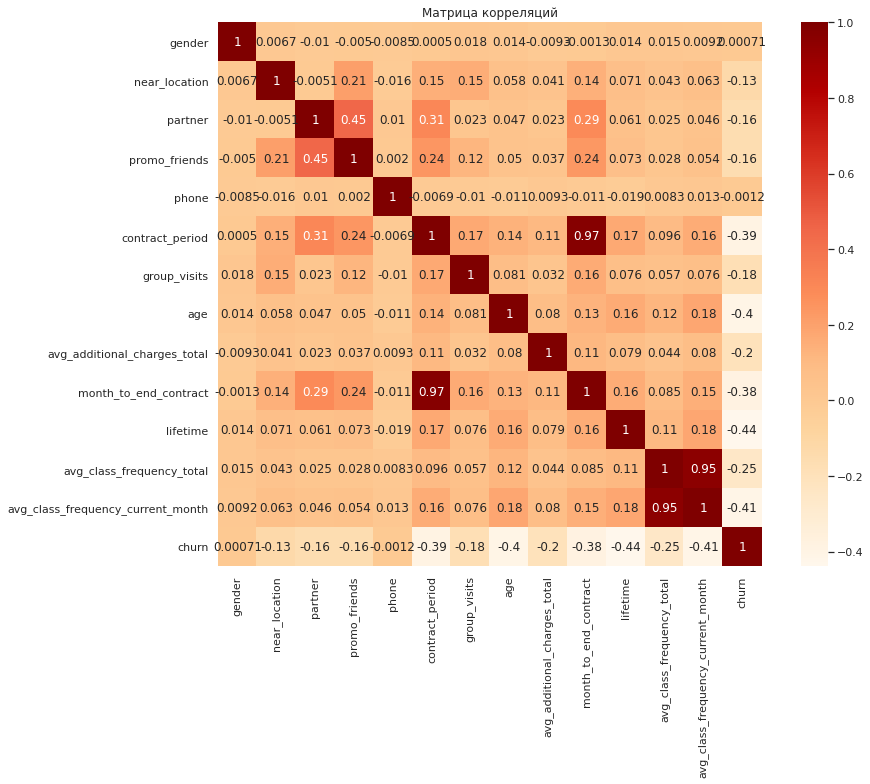

In [11]:
# Построим матрицу корреляций и отобразим её.
plt.figure(figsize=(14,10))
sns.heatmap(data = data.corr(), annot=True, square=True, cmap="OrRd")
plt.title('Матрица корреляций')
plt.show()

На матрице корреляции выделяются две сильные зависимости между:  
**contract_period** (длительность текущего действующего абонемента) и **month_to_end_contract** (срок окончания абонемента) - 0,97;  
**avg_class_frequency_total**(частота посещений в неделю) и **avg_class_frequency_current_month**(средняя частота посещений в неделю за предыдущий месяц) – 0,95.  

Эти зависимости очевидны и особо ни о чём не говорят. Сильной корреляции межу признаками и целевой переменной не наблюдается.  

Так же выявили две пары мультиколлинеарных признаков. Для дальнейшей работы  удалим из каждой пары по одному  


## Шаг 3. Построим модель прогнозирования оттока клиентов ##

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

### Разбьём данные на обучающую и валидационную выборку функцией train_test_split() ###

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'])
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



### Обучим модель на train-выборке двумя способами: логистической регрессией, случайным лесом.

In [14]:
# создадим объект класса StandardScaler для обучающей выборки
scaler = StandardScaler()
#обучаем
X_train_st = scaler.fit_transform(X_train)
#стандартизируем
X_test_st = scaler.transform(X_test)

In [15]:
#логистическая регрессия
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
print('Метрики для модели логистической регрессии:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, lr_predictions),
    precision_score(y_test, lr_predictions),
    recall_score(y_test, lr_predictions)
))

Метрики для модели логистической регрессии:
accuracy_score: 0.9225
precision_score: 0.8541666666666666
recall_score:0.8282828282828283


In [16]:
#случайный лес
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print('\nМетрики для модели случайного леса:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, rf_predictions),
    precision_score(y_test, rf_predictions),
    recall_score(y_test, rf_predictions)
))


Метрики для модели случайного леса:
accuracy_score: 0.915
precision_score: 0.8385416666666666
recall_score:0.8131313131313131


Показатели метрик accuracy(доля правильных ответов алгоритма), precision (точность) и recall (полнота) в модели логистической регрессии выше, следовательно данная модель лучше

## Шаг 4. Сделаем кластеризацию клиентов

### Стандартизируем данные

In [20]:

sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

### Постром матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

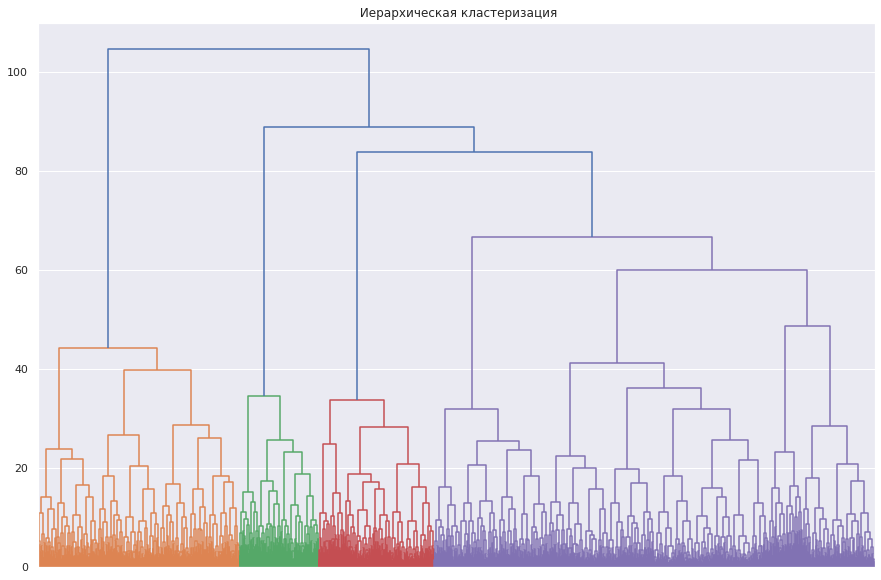

In [24]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title(' Иерархическая кластеризация')
plt.show()

На основании полученной дендрограммы выделим 5 кластеров

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [41]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state=0) 
labels = km.fit_predict(X_sc) 

### Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [43]:
df = data.groupby('cluster_km').mean()
df.T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


**Кластер 0**  
**Отток – около 3%**  
Живут или работают рядом с фитнес-центром – 95%  
Пользуются партнёрскими программами – 78%  
Пришли по акции «Приведи друга» - 57%  
Посещают групповые занятия – 54 %  
Покупают долгосрочные абонементы- примерно на 12 мес.  
Посещают занятия не менее 2-х раз в неделю

**Кластер 1**  
**Отток - 26%**  
Большая часть клиентов живёт и работает рядом с фитнес-центром  - 86%     
Пользуются партнёрскими программами – 47%  
Пришли по акции «Приведи друга» - 30%    
Посещают групповые занятия – 42 %  
Покупают долгосрочные абонементы- примерно на 12 мес.  
Посещают занятия примерно 2  раз в неделю  

**Кластер 2**  
**Отток – 44%**  
Живут или работают далеко от фитнес-центра  
Пользуются партнёрскими программами – 46%  
Пришли по акции «Приведи друга» - 7 %  
Посещают групповые занятия – 21 %  
Покупают краткосрочные абонементы, можно предположить, что это абонементы на месяц   
Посещают занятия в среднем 1,5 раза в неделю  

**Кластер 3**  
**Отток - 51 %**  
Живут или работают далеко от фитнес-центра  
Пользуются партнёрскими программами – 35%  
Пришли по акции «Приведи друга» - 24%     
Посещают групповые занятия – 34 %  
Покупают краткосрочные абонементы, можно предположить, что это абонементы на месяц   
Посещают занятия примерно 1  раз в неделю

**Кластер 4**  
**Отток – примерно 7 %**  
Живут или работают рядом с фитнес-центром – 97%  
Пользуются партнёрскими программами – 35%  
Пришли по акции «Приведи друга» - 23%  
Посещают групповые занятия – 47 %  
Покупают долгосрочные абонементы- примерно на 6 мес.  
Посещают занятия примерно 3 раз в неделю


### Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?

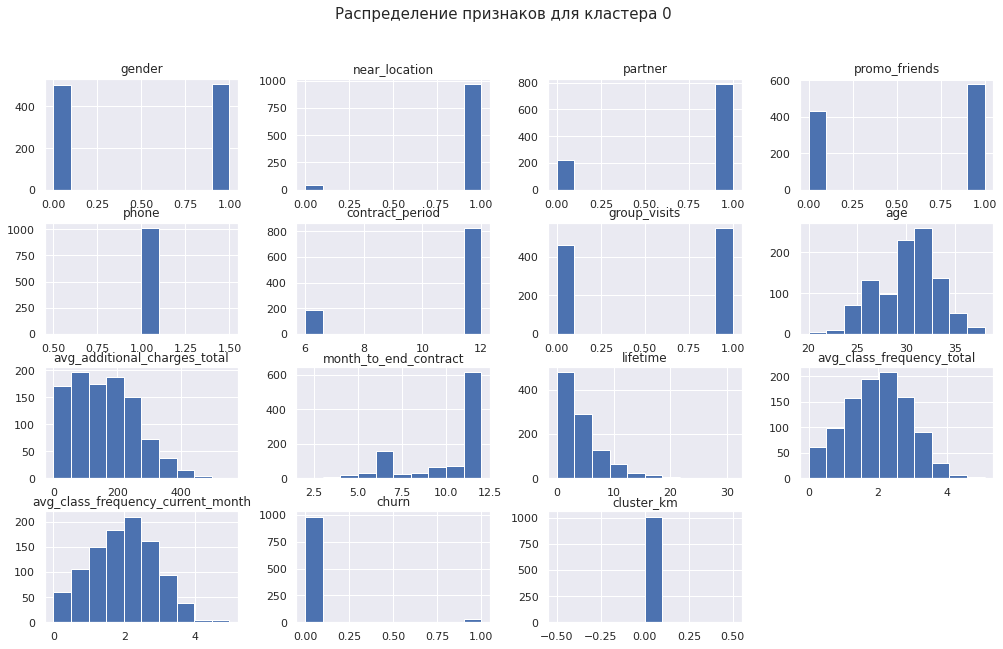

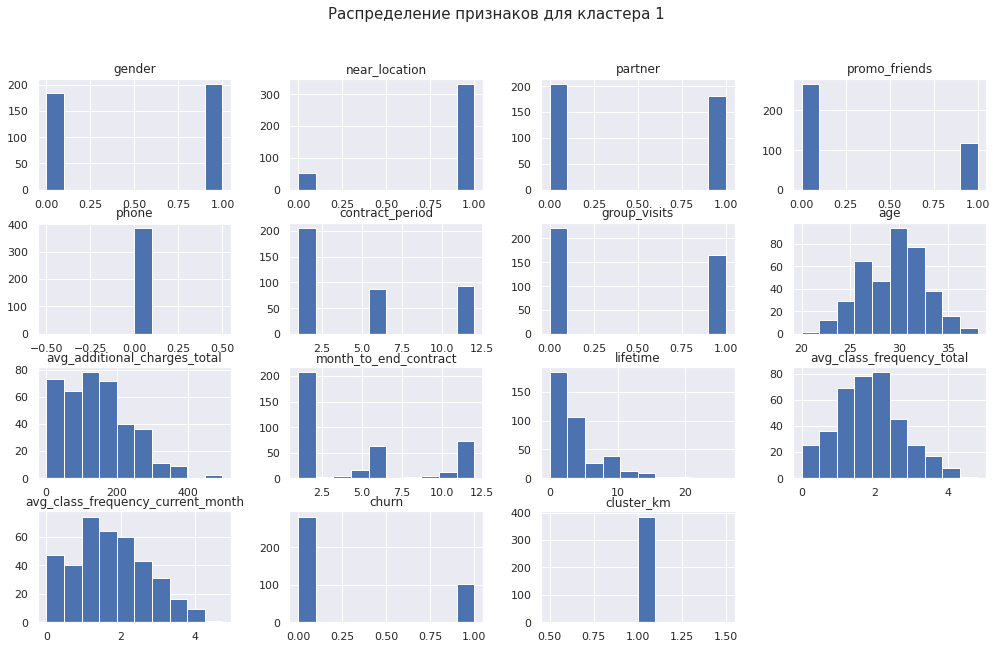

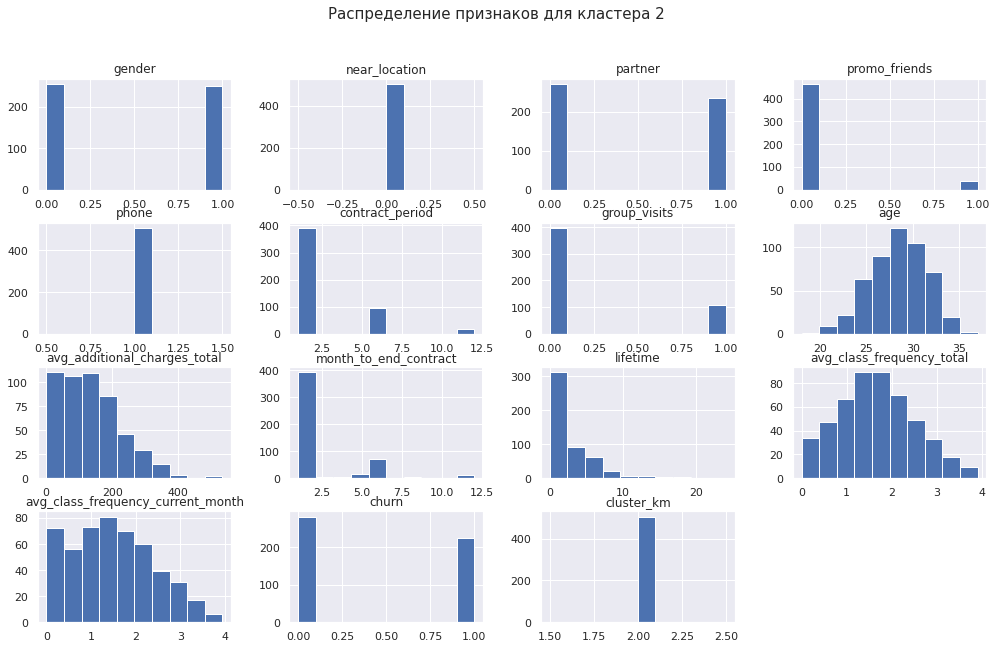

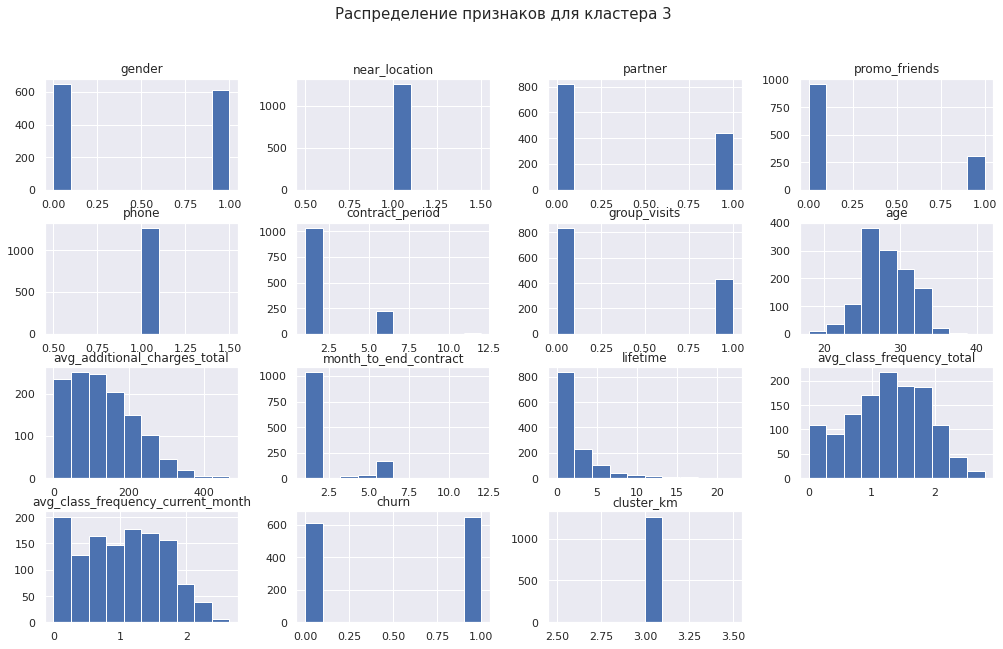

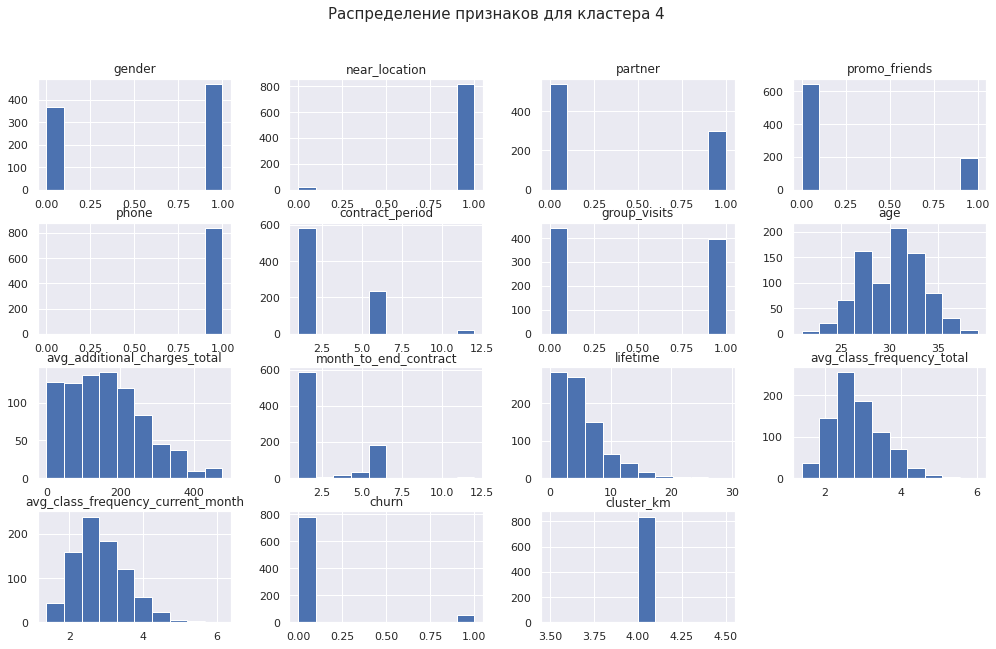

In [45]:
for value in [0, 1, 2, 3, 4]:
    data[data['cluster_km']==value].hist(figsize=(17,10))
    plt.suptitle('Распределение признаков для кластера {}'.format(value), fontsize = 15)
    plt.show()

Значения признаков распределилось согласно таблице выше. Каждый признак в кластерах можно рассмотреть более детально.

### Доля оттока

In [46]:
df_churn = data.groupby('cluster_km')['churn'].agg('sum') / data.groupby('cluster_km')['churn'].size()
display(df_churn)

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

Наименьший отток клиентов в **кластере 0 – примерно 3%**  
Далее по надёжности идет **кластер 4 – примерно 7%** оттока  
Остальные оказались менее надёжными:  
**Кластер 1 – 27%**  
**Кластер 2 – 44%**  
**Кластер 3 – 51%** 


## Итог:

В результате нашей работы и исследования данных, мы построили модель для прогнозирования оттока клиентов фитнес-центра. Данная модель описывает клиентов и их действия, которые приводят к оттоку, а также мы можем представить примерный портрет постоянных клиентов.  
Основные признаки клиентов, которые не долго задерживаются(кластер 0 и 4):
В основном они живут или работают далеко от фитнес-центра
Около половины из них пользуются партнёрскими программами
Примерно четверть из них пришли по акции «приведи друга»
Половина из них посещают групповые занятия
Заключают долгосрочные договора(абонементы) от 6 месяцев до 1 года
Посещают занятия от 2 до 4 раз  
По остальным признакам т.е возраст, наличие контактного телефона, пол и затраты на дополнительные услуги показатели в двух группах примерно одинаковы.

Рекомендации:  
В нашем случае прослеживается очевидная картина. Люди любят промо акции, плюшки от партнёров или профсоюзов. А ещё заниматься в группе (так веселей), и чтобы далеко ходить не надо…  
Отсюда можно сделать вывод, что, неважно у нас сеть клубов или один, нужно сосредоточиться на том, что рядом. Устроить рекламную акцию в ближайших бизнес – центрах, торговых центрах, учебных и лечебных заведениях. Пробные, групповые занятия или флеш мобы (допустим, занятия на открытом воздухе в ближайшем парке) тоже могут пойти на пользу всем. Ну и конечно скидки... Скидки на групповые занятия и долгосрочные абонементы
